In [14]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def style_diag(data):
    '''author: CJR, https://stackoverflow.com/a/56916315'''
    diag_mask = pd.DataFrame("", index=data.index, columns=data.columns)
    min_axis = min(diag_mask.shape)
    diag_mask.iloc[range(min_axis), range(min_axis)] = 'background-color: yellow'
    return diag_mask

# Metric Analysis: Landcover Prediction

### DataFrame (raw pixel count)

In [16]:
mimer = '/mimer/NOBACKUP/groups/globalpoverty1/albin_and_albin/raw_count_confusion_matrices/single_year_model/country_wise/'

COUNTRY = 'Gabon'
country_metrics = mimer + f'confusion_matrix_esri_urban_rural_{COUNTRY}.csv'

df_raw_count = pd.read_csv(country_metrics, index_col=0)
df_raw_count.style.apply(style_diag, axis=None).format(precision=3)

,c1:Water,c2:Tree,c3:Flooded Vegetation,c4:Crops,c5:Bare Ground,c6:Rangeland,c7:Rural,c8:Urban
c1:Water,38663618,222726,3036055,501,7129,51983,19250,12749
c2:Tree,3472470,2218402547,43495144,943473,1286,13851959,2743208,512039
c3:Flooded Vegetation,89909,199217,8753989,8076,0,207581,10641,5674
c4:Crops,3165,734056,141452,2229971,184,866929,115385,54086
c5:Bare Ground,109496,758608,213338,22736,12607,130188,65484,22712
c6:Rangeland,71417,8976945,7853063,12270581,2743,136914829,710208,77410
c7:Rural,4804,83936,55612,12589,1,53529,852888,675509
c8:Urban,3232,23369,68715,5372,0,36139,427706,2593847


In [17]:
df_raw_count.sum(axis=1)

c1:Water                   42014011
c2:Tree                  2283422126
c3:Flooded Vegetation       9275087
c4:Crops                    4145228
c5:Bare Ground              1335169
c6:Rangeland              166877196
c7:Rural                    1738868
c8:Urban                    3158380
dtype: int64

In [18]:
df_new = df_raw_count.sum(axis=1)
df_new = df_new.div(df_new.sum(axis=0), axis=0)
df_new

c1:Water                 0.016726
c2:Tree                  0.909018
c3:Flooded Vegetation    0.003692
c4:Crops                 0.001650
c5:Bare Ground           0.000532
c6:Rangeland             0.066433
c7:Rural                 0.000692
c8:Urban                 0.001257
dtype: float64

# Recall

### DataFrame (recall)

In [19]:
df_recall = df_raw_count.div(df_raw_count.sum(axis=1), axis=0)
df_recall.style.apply(style_diag, axis=None).format(precision=3)

,c1:Water,c2:Tree,c3:Flooded Vegetation,c4:Crops,c5:Bare Ground,c6:Rangeland,c7:Rural,c8:Urban
c1:Water,0.920,0.005,0.072,0.000,0.000,0.001,0.000,0.000
c2:Tree,0.002,0.972,0.019,0.000,0.000,0.006,0.001,0.000
c3:Flooded Vegetation,0.010,0.021,0.944,0.001,0.000,0.022,0.001,0.001
c4:Crops,0.001,0.177,0.034,0.538,0.000,0.209,0.028,0.013
c5:Bare Ground,0.082,0.568,0.160,0.017,0.009,0.098,0.049,0.017
c6:Rangeland,0.000,0.054,0.047,0.074,0.000,0.820,0.004,0.000
c7:Rural,0.003,0.048,0.032,0.007,0.000,0.031,0.490,0.388
c8:Urban,0.001,0.007,0.022,0.002,0.000,0.011,0.135,0.821


### Seaborn Heatmap (Recall)

Text(0.5, 23.52222222222222, 'Predicted label')

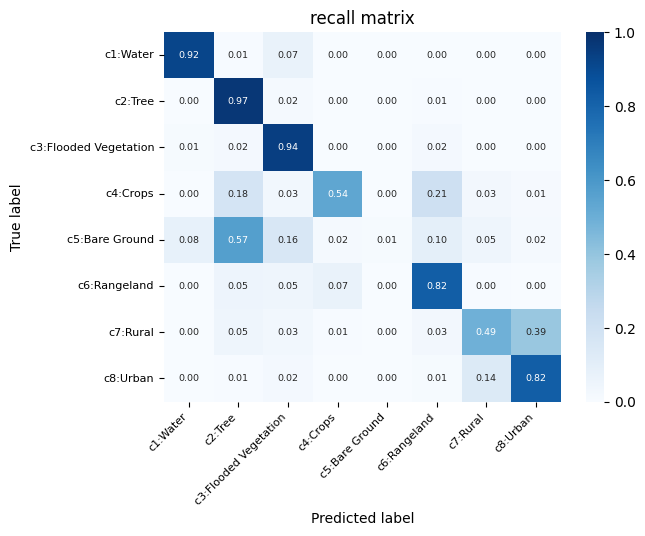

In [20]:
heatmap = sns.heatmap(data=df_recall, vmin=0.0, vmax=1.0, cmap=plt.cm.Blues, annot=True, annot_kws={"fontsize":6.8}, fmt='.2f')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=8)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=8)
plt.title('recall matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Recall score (per class accuracy)

In [21]:
class_names = df_recall.columns
confmat_diag = df_recall.to_numpy().diagonal()
per_class_acc = dict(zip(class_names, confmat_diag))
recall_scores = pd.DataFrame(per_class_acc.items(), columns=['class', 'recall'])
recall_scores.round(3)

,class,recall
0,c1:Water,0.920
1,c2:Tree,0.972
2,c3:Flooded Vegetation,0.944
3,c4:Crops,0.538
4,c5:Bare Ground,0.009
5,c6:Rangeland,0.820
6,c7:Rural,0.490
7,c8:Urban,0.821


In [22]:
confmat_diag

array([0.92025534, 0.97152538, 0.94381745, 0.537961  , 0.00944225,
       0.8204526 , 0.49048461, 0.82125868])

# Precision

### DataFrame (precision)

In [23]:
df_precision = df_raw_count.div(df_raw_count.sum(axis=0), axis=1)
df_precision.style.apply(style_diag, axis=None).format(precision=3)

,c1:Water,c2:Tree,c3:Flooded Vegetation,c4:Crops,c5:Bare Ground,c6:Rangeland,c7:Rural,c8:Urban
c1:Water,0.911,0.000,0.048,0.000,0.298,0.000,0.004,0.003
c2:Tree,0.082,0.995,0.684,0.061,0.054,0.091,0.555,0.129
c3:Flooded Vegetation,0.002,0.000,0.138,0.001,0.000,0.001,0.002,0.001
c4:Crops,0.000,0.000,0.002,0.144,0.008,0.006,0.023,0.014
c5:Bare Ground,0.003,0.000,0.003,0.001,0.526,0.001,0.013,0.006
c6:Rangeland,0.002,0.004,0.123,0.792,0.115,0.900,0.144,0.020
c7:Rural,0.000,0.000,0.001,0.001,0.000,0.000,0.172,0.171
c8:Urban,0.000,0.000,0.001,0.000,0.000,0.000,0.086,0.656


### Seaborn Heatmap (Precision)

Text(0.5, 23.52222222222222, 'Predicted label')

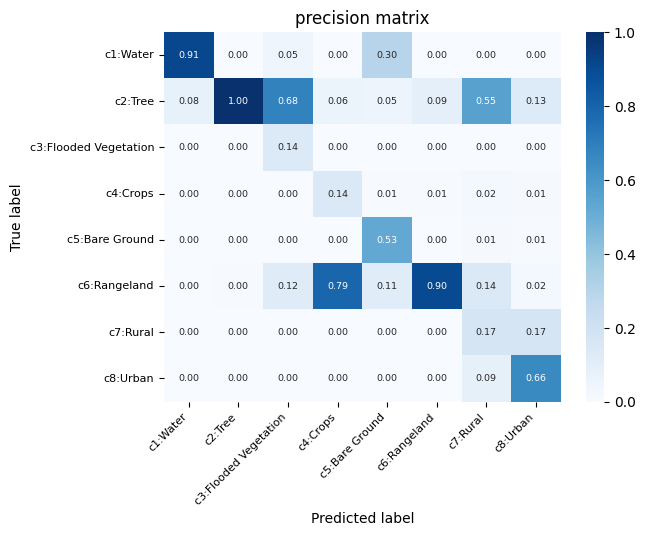

In [24]:
heatmap = sns.heatmap(data=df_precision, vmin=0.0, vmax=1.0, cmap=plt.cm.Blues, annot=True, annot_kws={"fontsize":6.8}, fmt='.2f')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=8)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=8)
plt.title('precision matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Precision score (prediction accuracy)

In [25]:
class_names = df_precision.columns
confmat_diag = df_precision.to_numpy().diagonal()
per_class_acc = dict(zip(class_names, confmat_diag))
precision_scores = pd.DataFrame(per_class_acc.items(), columns=['class', 'precision'])
precision_scores.round(3)

,class,precision
0,c1:Water,0.911
1,c2:Tree,0.995
2,c3:Flooded Vegetation,0.138
3,c4:Crops,0.144
4,c5:Bare Ground,0.526
5,c6:Rangeland,0.900
6,c7:Rural,0.172
7,c8:Urban,0.656


In [26]:
confmat_diag

array([0.91148844, 0.99506645, 0.13760376, 0.14393132, 0.52638831,
       0.9000855 , 0.17248285, 0.6560015 ])

# IoU

In [27]:
class_names = df_raw_count.columns
raw_counts = df_raw_count.to_numpy()
iou_class = {}

# calculate IoU for each class
for i in range(len(class_names)):
    tp = raw_counts[i, i]
    fp = raw_counts[:, i].sum() - tp
    fn = raw_counts[i, :].sum() - tp
    
    nom = tp
    denom = (tp + fp + fn)
    
    if denom != 0:
        iou = nom / denom
    else:
        iou = np.NaN
    iou_class[class_names[i]] = iou


# output IoU as dataframe
iou_scores = pd.DataFrame(iou_class.items(), columns=['class', 'IoU'])
iou_scores.round(3)

,class,IoU
0,c1:Water,0.845
1,c2:Tree,0.967
2,c3:Flooded Vegetation,0.136
3,c4:Crops,0.128
4,c5:Bare Ground,0.009
5,c6:Rangeland,0.752
6,c7:Rural,0.146
7,c8:Urban,0.574


In [28]:
# calculate mean IoU (not counting empty classes)
iou_mean = np.nanmean(iou_scores['IoU'])
(iou_mean*8) / 7

0.5082660095296195

# F1 Score (Dice coefficient)

In [29]:
class_names = df_raw_count.columns
raw_counts = df_raw_count.to_numpy()
f1_class = {}

# calculate IoU for each class
for i in range(len(class_names)):
    tp = raw_counts[i, i]
    fp = raw_counts[:, i].sum() - tp
    fn = raw_counts[i, :].sum() - tp
    
    nom = tp
    denom = tp + 0.5*(fp + fn)
    
    if denom != 0:
        f1 = nom / denom
    else:
        f1 = np.NaN
    f1_class[class_names[i]] = f1

# output f1-score as dataframe
f1_scores = pd.DataFrame(f1_class.items(), columns=['class', 'f1-score'])
f1_scores.round(3)

,class,f1-score
0,c1:Water,0.916
1,c2:Tree,0.983
2,c3:Flooded Vegetation,0.240
3,c4:Crops,0.227
4,c5:Bare Ground,0.019
5,c6:Rangeland,0.858
6,c7:Rural,0.255
7,c8:Urban,0.729


In [30]:
# calculate mean f1-score (not counting empty classes)
f1_mean = np.nanmean(f1_scores['f1-score'])
f1_mean

0.528484752243471